In [1]:
import os
import pickle
from datetime import datetime, timedelta
from glob import glob

import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import pandas as pd
from minisom import MiniSom
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, num2date
from tqdm import tqdm

In [2]:
case_to_vec = {"on": [1.0, 0.0], "off": [0.0, 1.0]}
col_re = {0: "date_int", 1: "on", 2: "off"}
source_dir = "/work/unuu/SOM/CESM/scenarios"


def col_rename(i):
    if i in col_re:
        return col_re[i]
    return "TREFHT" + str(i - 3)

<h1> Data preprocessing </h1>
<strong> If ran once, do not need to run again. </strong>

<h2> Data exploration </h2>

In [3]:
source_dir = "/work/unuu/SOM/CESM/scenarios"
file_names = os.listdir(f"{source_dir}/Asia/")
print(sorted(file_names))

['BSSP585_urbanhacoff_2020.nc', 'BSSP585_urbanhacoff_2021.nc', 'BSSP585_urbanhacoff_2022.nc', 'BSSP585_urbanhacoff_2023.nc', 'BSSP585_urbanhacoff_2024.nc', 'BSSP585_urbanhacoff_2025.nc', 'BSSP585_urbanhacoff_2026.nc', 'BSSP585_urbanhacoff_2027.nc', 'BSSP585_urbanhacoff_2028.nc', 'BSSP585_urbanhacoff_2029.nc', 'BSSP585_urbanhacoff_2030.nc', 'BSSP585_urbanhacoff_2031.nc', 'BSSP585_urbanhacoff_2032.nc', 'BSSP585_urbanhacoff_2033.nc', 'BSSP585_urbanhacoff_2034.nc', 'BSSP585_urbanhacoff_2035.nc', 'BSSP585_urbanhacoff_2036.nc', 'BSSP585_urbanhacoff_2037.nc', 'BSSP585_urbanhacoff_2038.nc', 'BSSP585_urbanhacoff_2039.nc', 'BSSP585_urbanhacoff_2040.nc', 'BSSP585_urbanhacoff_2041.nc', 'BSSP585_urbanhacoff_2042.nc', 'BSSP585_urbanhacoff_2043.nc', 'BSSP585_urbanhacoff_2044.nc', 'BSSP585_urbanhacon_2020.nc', 'BSSP585_urbanhacon_2021.nc', 'BSSP585_urbanhacon_2022.nc', 'BSSP585_urbanhacon_2023.nc', 'BSSP585_urbanhacon_2024.nc', 'BSSP585_urbanhacon_2025.nc', 'BSSP585_urbanhacon_2026.nc', 'BSSP585_urban

In [4]:
dirs = glob(f"{source_dir}/Asia/*")
print(dirs[0])
df = Dataset(dirs[0])
print(df)

/work/unuu/SOM/CESM/scenarios/Asia/BSSP585_urbanhacon_2037.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    CDI: Climate Data Interface version 1.9.8 (https://mpimet.mpg.de/cdi)
    Conventions: CF-1.0
    history: Wed Feb 16 18:06:44 2022: ncks -d lon,90.,165. -d lat,-15.,45. BSSP585_urbanhacon_2037.nc ./Asia/BSSP585_urbanhacon_2037.nc
Tue Feb 08 12:15:32 2022: cdo -O -selvar,lat,lon,gw,lev,hyam,hybm,date,datesec,time,PRECC,PRECL,TREFHT,U10 -mergetime /gucnas1/sims/CESM/BSSP585cmip6_fast/atm/hist/BSSP585cmip6_fast.cam.h0.2037-01.nc /gucnas1/sims/CESM/BSSP585cmip6_fast/atm/hist/BSSP585cmip6_fast.cam.h0.2037-02.nc /gucnas1/sims/CESM/BSSP585cmip6_fast/atm/hist/BSSP585cmip6_fast.cam.h0.2037-03.nc /gucnas1/sims/CESM/BSSP585cmip6_fast/atm/hist/BSSP585cmip6_fast.cam.h0.2037-04.nc /gucnas1/sims/CESM/BSSP585cmip6_fast/atm/hist/BSSP585cmip6_fast.cam.h0.2037-05.nc /gucnas1/sims/CESM/BSSP585cmip6_fast/atm/hist/BSSP585cmip6_fast.cam.h0.20

In [5]:
for key in df.dimensions:
    print(f"----- DIMENSION: {key} -----")
    print(df.dimensions[key])
for key in df.variables:
    print(f"----- VARIABLE: {key} -----")
    print(df.variables[key])

----- DIMENSION: time -----
<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 12
----- DIMENSION: lat -----
<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 64
----- DIMENSION: lon -----
<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 61
----- DIMENSION: bnds -----
<class 'netCDF4._netCDF4.Dimension'>: name = 'bnds', size = 2
----- VARIABLE: PRECC -----
<class 'netCDF4._netCDF4.Variable'>
float32 PRECC(time, lat, lon)
    long_name: Convective precipitation rate (liq + ice)
    units: m/s
    cell_methods: time: mean
unlimited dimensions: time
current shape = (12, 64, 61)
filling on, default _FillValue of 9.969209968386869e+36 used
----- VARIABLE: PRECL -----
<class 'netCDF4._netCDF4.Variable'>
float32 PRECL(time, lat, lon)
    long_name: Large-scale (stable) precipitation rate (liq + ice)
    units: m/s
    cell_methods: time: mean
unlimited dimensions: time
current shape = (12, 64, 61)
filling on, default _FillValue of 9.969209968386869e+36 

Now, we can see that <strong> TREFHT </strong> variable is the most important piece of data. Moreover, we can sort by the variable <strong> time </strong>.
Here, notice the shape of <strong> TREFHT </strong> is (12, 64, 61).

In [6]:
print(df.variables["TREFHT"].shape)

(12, 64, 61)


As we suspect due to Alvin sensei's experiment, passing the data as it is (not the changes) will force the model to map the current geophysical characteristics of the earth. Logically, switching ac on/off could have an effect on the <strong> change </strong> in the temperatures. Not the already set situation. Therefore, for the first iteration, we will consider the collowing in 1 row for the training data:
<ol>
    <li> Flattened TREFT difference between certain timestep and the date before that. </li>
    <li> One-hot-encoding of <em> "on" </em> or <em> "off" </em> states. In other words, <em> "on" </em> will become [1,0] whereas <em> "off" </em> will become [0,1]. </li>
</ol>

<h2> Data preparation </h2>

First, let's prepare the data for each month.

In [7]:
for case in case_to_vec.keys():  # For readability
    case_files = glob(f"{source_dir}/Asia/*urbanhac{case}*.nc")
    datas = []  # List of rows
    for file in case_files:
        dset = Dataset(file)
        row = 0
        for i, date in enumerate(dset.variables["date"]):
            row = np.concatenate(
                (
                    [date.data],
                    case_to_vec[case],
                    dset.variables["TREFHT"][i, :, :].data.flatten() - 273.15,
                )
            )  # Appending a row
            datas.append(row)
    datas = np.array(datas)
    df = pd.DataFrame(data=datas)
    df = df.rename(columns=lambda x: col_rename(x))
    df["d_time"] = pd.to_datetime(df["date_int"].astype(str), format="%Y%m%d")
    df.drop(columns="date_int", inplace=True)
    df.insert(0, "d_time", df.pop("d_time"))
    df.sort_values("d_time", ignore_index=True, inplace=True)
    df.to_pickle(
        f"TREFHT_Asia/sample/urbanhac{case}.pickle"
    )  # Saved for difference demonstration.

Next, calculate changes between timesteps.

In [8]:
for case in case_to_vec.keys():
    df = pd.read_pickle(f"TREFHT_Asia/sample/urbanhac{case}.pickle")
    datas = df.values
    datas[:, 4:] = datas[:, 4:] - np.roll(datas[:, 4:], shift=-1, axis=0)
    datas = datas[1:, :]
    df = pd.DataFrame(data=datas)
    df = df.rename(columns=lambda x: col_rename(x))
    df.to_pickle(f"TREFHT_Asia/t_steps/urbanhac{case}.pickle")  # Saved for training.

In [22]:
dirs = glob(f"{source_dir}/Asia/*")
df_source = Dataset(dirs[0])
lats = np.ma.getdata(df_source.variables["lat"][:])
lons = np.ma.getdata(df_source.variables["lon"][:])
dictionary = {"lat": lats, "lon": lons}

with open(f"TREFHT_Asia/metadata.pickle", "wb") as f:
    pickle.dump(dictionary, f)

Now, we have both ac on/off time step datas prepared.

<h1> Data loading </h1>

In [3]:
print("\t#########################################################")
print("\t---Temperatures in Celsius (to demonstrate unexpected)---")
print("\t#########################################################")
comparison = {}
for case in case_to_vec.keys():
    df = pd.read_pickle(f"TREFHT_Asia/sample/urbanhac{case}.pickle")
    print(df.iloc[:, :5].head())
    for year in ("2020", "2030", "2040"):
        for month in ("02", "05", "08", "11"):
            comparison[f"{case}_{year}_{month}"] = (
                df.loc[df["d_time"] == f"{year}-{month}-01"].values[0, 3:].astype(float)
            )
print("\t############################################")
print("\t---Temperature differences (for training)---")
print("\t############################################")
train_datas = {}
for case in case_to_vec.keys():
    df = pd.read_pickle(f"TREFHT_Asia/t_steps/urbanhac{case}.pickle")
    print(df.iloc[:, :5].head())
    train_datas[case] = df.values[:, 3:].astype(float)

with open(f"TREFHT_Asia/metadata.pickle", "rb") as f:
    metas = pickle.load(f)

	#########################################################
	---Temperatures in Celsius (to demonstrate unexpected)---
	#########################################################
      d_time   on  off    TREFHT0    TREFHT1
0 2020-02-01  1.0  0.0  26.447327  26.373901
1 2020-03-01  1.0  0.0  25.878265  25.785004
2 2020-04-01  1.0  0.0  26.238251  26.233032
3 2020-05-01  1.0  0.0  25.291443  25.324890
4 2020-06-01  1.0  0.0  24.339050  24.298065
      d_time   on  off    TREFHT0    TREFHT1
0 2020-02-01  0.0  1.0  26.530823  26.369476
1 2020-03-01  0.0  1.0  25.898407  25.933350
2 2020-04-01  0.0  1.0  25.969635  25.978638
3 2020-05-01  0.0  1.0  26.403992  26.407074
4 2020-06-01  0.0  1.0  25.582184  25.635406
	############################################
	---Temperature differences (for training)---
	############################################
    date_int   on  off    TREFHT0   TREFHT1
0 2020-03-01  1.0  0.0  25.878265 -0.448029
1 2020-04-01  1.0  0.0  26.238251  0.908142
2 2020-05-01 

<h1> Visualization </h1>

Common sense dictates that if the whole words turns off their AC and the CO2 emmission is maximized, the global warming would certainly worsen. However, since we have the ability to see it for ourselves, why leave it up to common sense?

In [4]:
def visualize(year_month, cmap="jet", metas=metas):
    lats, lons = metas["lat"], metas["lon"]
    shape = (len(lats), len(lons))

    arr2d_on = np.reshape(comparison[f"on_{year_month}"], shape)
    arr2d_off = np.reshape(comparison[f"off_{year_month}"], shape)
    arr2d_del = arr2d_on - arr2d_off

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 4))
    fig.suptitle(f"Comparison of {year_month}. On/Off (Left/Right)")

    vmin, vmax = np.percentile(arr2d_on, (0, 100))
    ax1.set_title("AC on")
    m = Basemap(
        llcrnrlon=np.min(lons),
        llcrnrlat=np.min(lats),
        urcrnrlon=np.max(lons),
        urcrnrlat=np.max(lats),
        resolution="c",
        ax=ax1,
    )
    lon_grids, lat_grids = m.makegrid(*shape[::-1])
    x, y = m(lon_grids, lat_grids)
    p_cels1 = ax1.pcolormesh(x, y, arr2d_on, cmap=cmap, vmin=vmin, vmax=vmax)

    ax2.set_title("AC off")
    m = Basemap(
        llcrnrlon=np.min(lons),
        llcrnrlat=np.min(lats),
        urcrnrlon=np.max(lons),
        urcrnrlat=np.max(lats),
        resolution="c",
        ax=ax2,
    )
    lon_grids, lat_grids = m.makegrid(*shape[::-1])
    x, y = m(lon_grids, lat_grids)
    p_cels2 = ax2.pcolormesh(x, y, arr2d_off, cmap=cmap, vmin=vmin, vmax=vmax)

    vmin, vmax = np.percentile(arr2d_del, (0, 100))
    ax3.set_title("T diff (on-off)")
    m = Basemap(
        llcrnrlon=np.min(lons),
        llcrnrlat=np.min(lats),
        urcrnrlon=np.max(lons),
        urcrnrlat=np.max(lats),
        resolution="c",
        ax=ax3,
    )
    lon_grids, lat_grids = m.makegrid(*shape[::-1])
    x, y = m(lon_grids, lat_grids)
    p_diff = ax3.pcolormesh(x, y, arr2d_del, cmap=plt.cm.seismic, vmin=vmin, vmax=vmax)

    cels1 = plt.colorbar(p_cels1, ax=ax1)
    cels2 = plt.colorbar(p_cels2, ax=ax2)
    diff = plt.colorbar(p_diff, ax=ax3)
    cels1.set_label("Temperature (C)")
    cels2.set_label("Temperature (C)")
    diff.set_label("Difference (On-Off)")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    return None

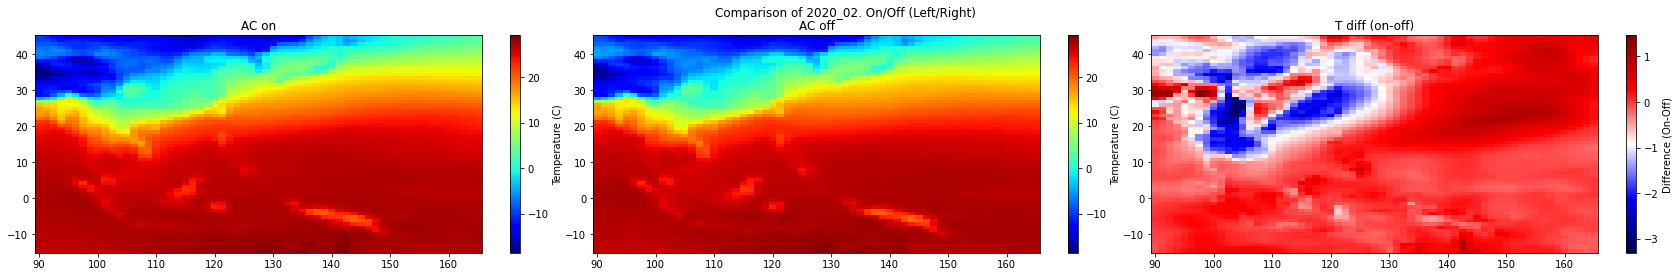

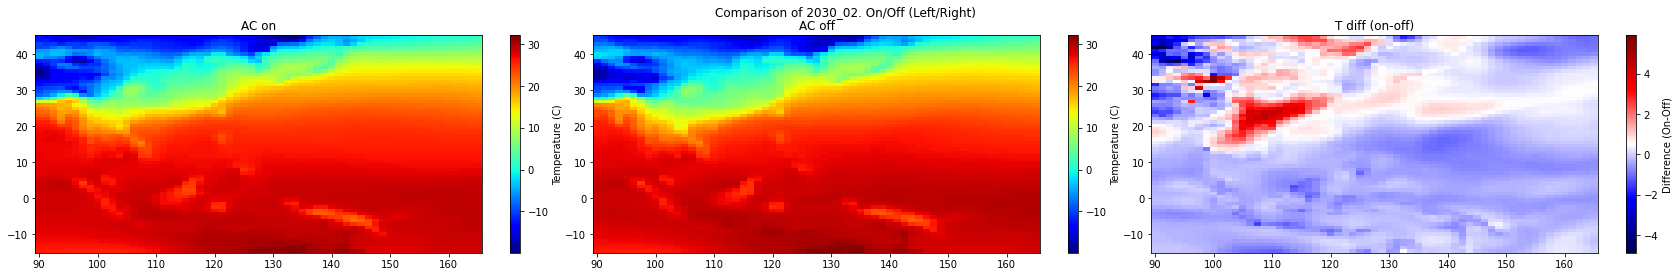

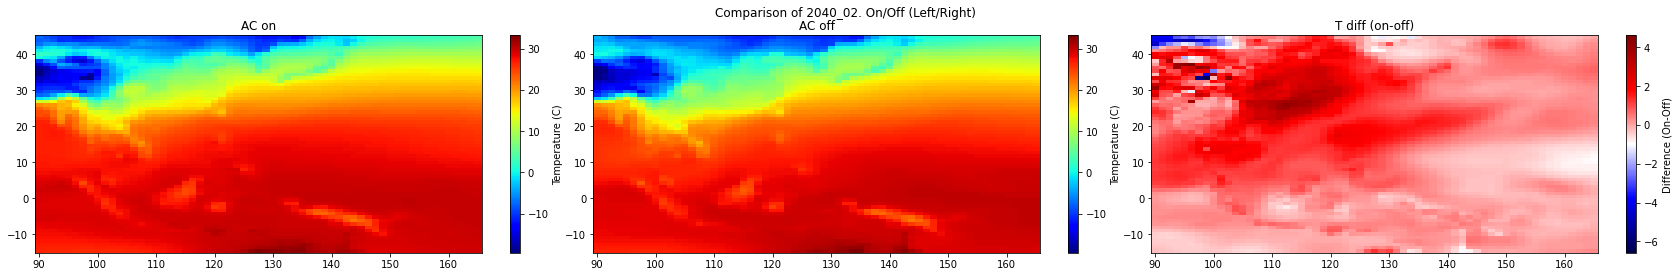

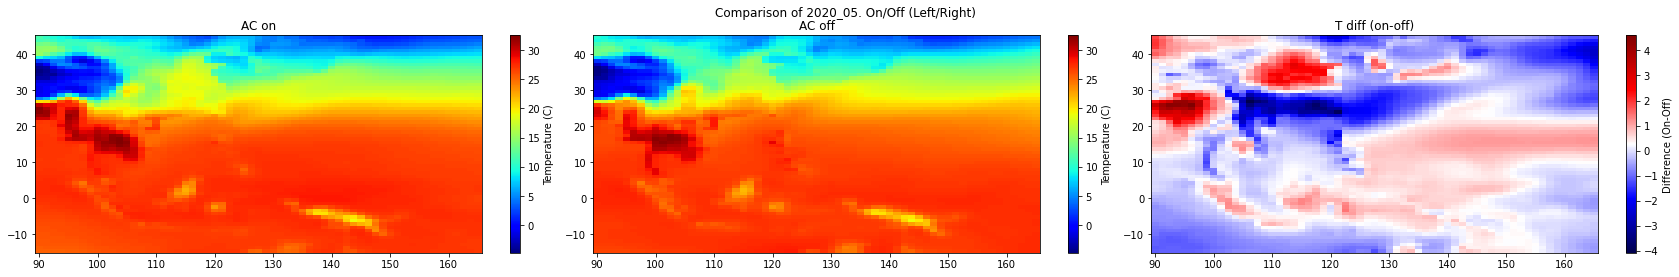

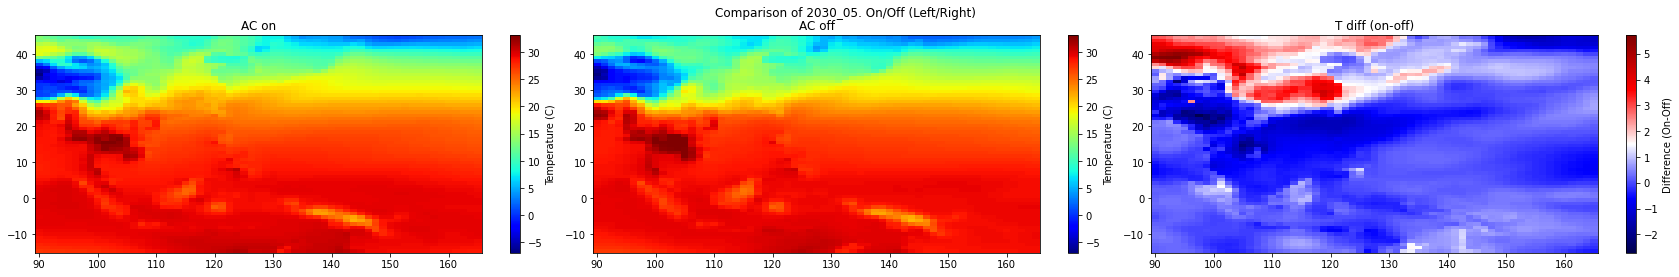

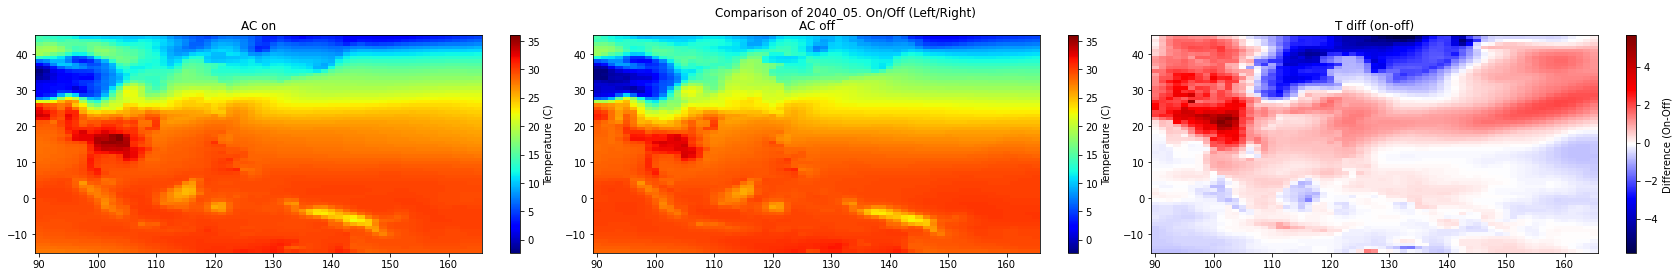

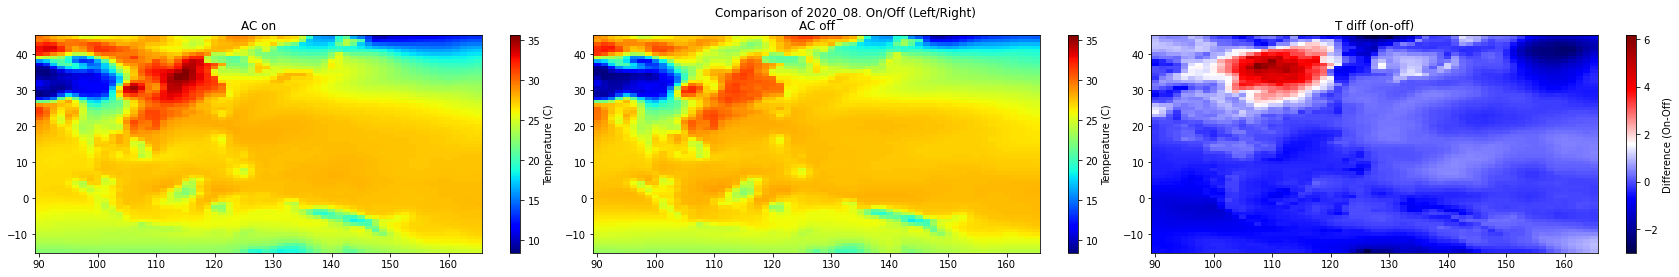

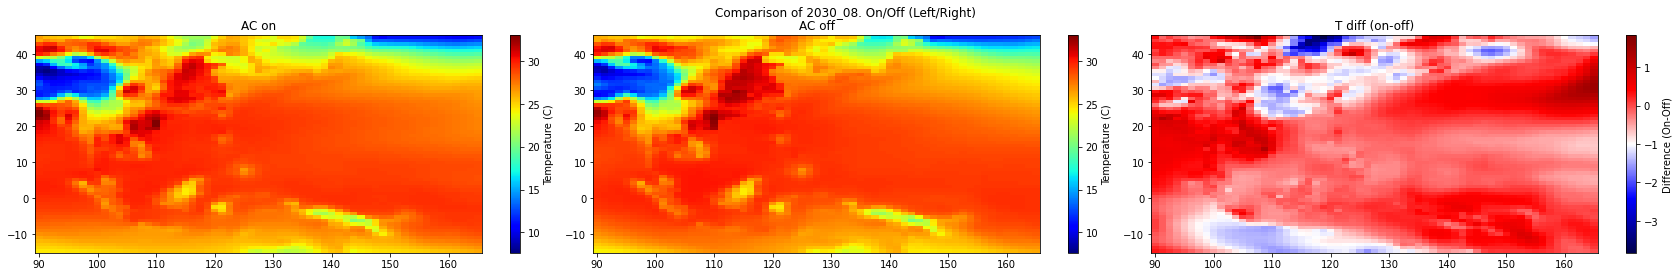

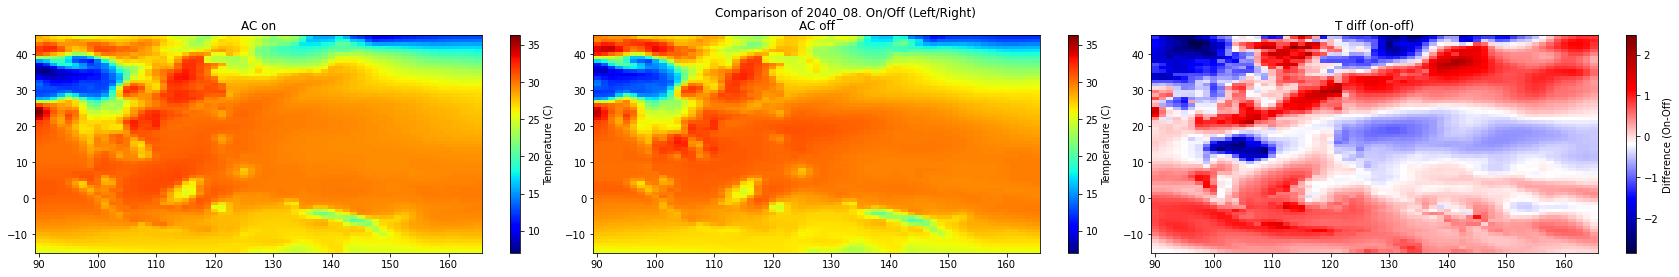

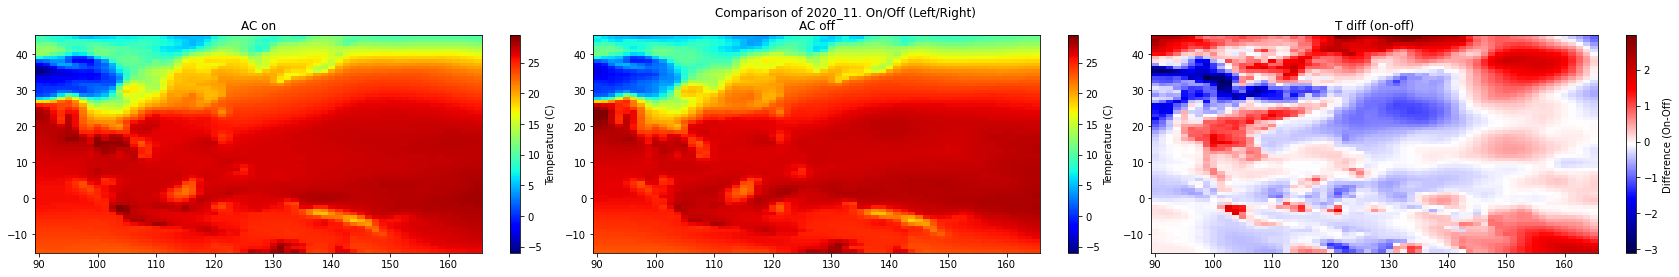

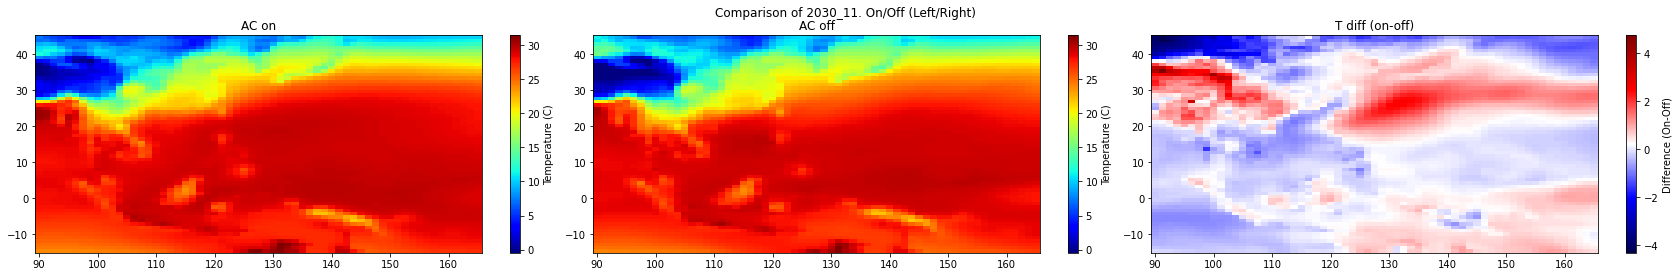

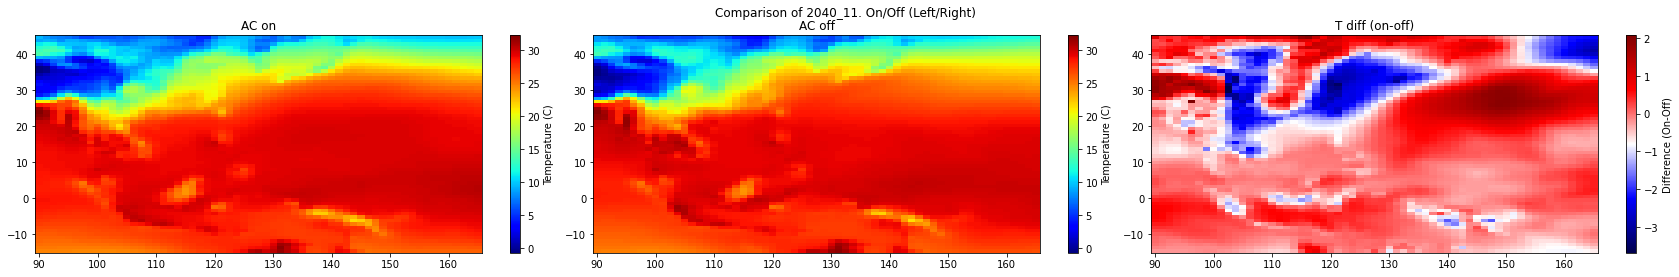

In [5]:
for month in ("02", "05", "08", "11"):
    for year in ("2020", "2030", "2040"):
        visualize(f"{year}_{month}")

<h1> SOM </h1>

First, we will test SOM (self organizing map) method.

SOM is a unsupervised method which highlights which entries in the data are close to each other and which are not. This method takes data with any dimension (preferrably with same data type and without categorical data) and reduces the dimensions into 2d.

For the first iteration, we will try training on the whole dataset of temperature changes of timesteps (case on and off) and see if the output for each case are clustered separately.

<h2> Data prep (final) </h2>

In [6]:
data = []
for key in train_datas.keys():
    data_tmp = train_datas[key]
    data.append(data_tmp)
    print(f"Data of case {key} has been added")
    print(
        f"\tmax:{np.max(data_tmp)}, min:{np.min(data_tmp)}, mean:{np.mean(data_tmp)}, stdev:{np.std(data_tmp)}"
    )
data = np.concatenate(np.array(data))

full_max, full_min, full_mean, full_std = (
    np.max(data),
    np.min(data),
    np.mean(data),
    np.std(data),
)
print(f"\nThe whole data has:")
print(f"\tmax:{full_max}, min:{full_min}, mean:{full_mean}, stdev:{full_std}")
data = (data - full_min) / (full_max - full_min)
s_n = len(data)
dims = round(np.ceil(np.sqrt(5 * np.sqrt(s_n))))
print(f"Number of samples: {s_n}. So we need {dims} by {dims} map.")

Data of case on has been added
	max:28.802703857421875, min:-20.00115966796875, mean:0.005784517200155617, stdev:2.7806233232134043
Data of case off has been added
	max:28.882965087890625, min:-18.059722900390625, mean:0.0072142109352478665, stdev:2.7552654839165465

The whole data has:
	max:28.882965087890625, min:-20.00115966796875, mean:0.006499364067701742, stdev:2.7679735344175826
Number of samples: 598. So we need 12 by 12 map.


<h2> Training SOM </h2>

<h3> Initial assessment </h3>

For this part, we will test the hyperparameters of the previous attempt.

In [7]:
print(data.shape)
print(np.mean(data, axis=0))

(598, 3904)
[0.93466743 0.40911944 0.40912497 ... 0.4090863  0.40908004 0.40907777]


In [28]:
som = MiniSom(
    12,
    12,
    data.shape[1],
    sigma=1,
    learning_rate=0.5,
    neighborhood_function="gaussian",
    topology = 'hexagonal',
    random_seed=0,
)
som.random_weights_init(data)

In [29]:
som.train(data, 10000, verbose=True)
with open("som.p", "wb") as outfile:
    pickle.dump(som, outfile)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.7605129390812649


<h4> Checking if the training process went correctly. </h4>

100%|█████████████████████████████████████| 10000/10000 [10:01<00:00, 16.62it/s]


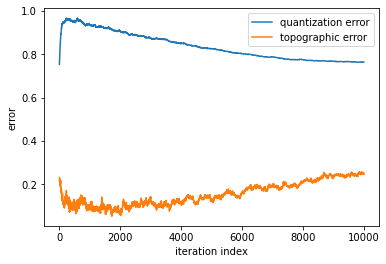

In [13]:
max_iter = 10000
q_error = []
t_error = []

for i in tqdm(range(max_iter)):
    rand_i = np.random.randint(len(data))
    som.update(data[rand_i], som.winner(data[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(data))
    t_error.append(som.topographic_error(data))

plt.plot(np.arange(max_iter), q_error, label="quantization error")
plt.plot(np.arange(max_iter), t_error, label="topographic error")
plt.ylabel("error")
plt.xlabel("iteration index")
plt.legend()
plt.show()

# with open("som.p", "wb") as outfile:
#     pickle.dump(som, outfile)

<h4> Sample projection </h4>

Load the trained model.

In [30]:
with open("som.p", "rb") as infile:
    som = pickle.load(infile)

Sample preparation is done by sampling 20 rows from each case and passing it to the model. </br>
First, we prepare the data.

In [31]:
sample_datas = {}
for case in train_datas.keys():
    n_rows = train_datas[case].shape[0]
    random_indices = np.random.choice(n_rows, size=20, replace=False)
    sample_datas[case] = train_datas[case][random_indices, :]
    print(sample_datas[case].shape)

(20, 3904)
(20, 3904)


Next, we plot sample datas of 2 different cases' projection.

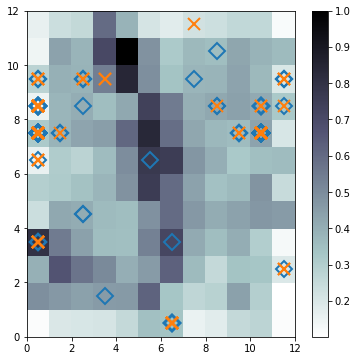

In [32]:
plt.figure(figsize=(6, 6))

plt.pcolor(
    som.distance_map().T, cmap="bone_r"
)  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label
markers = {"on": "D", "off": "x"}
colors = {"on": "C0", "off": "C1"}
for case in sample_datas.keys():
    for i, sample in enumerate(train_datas[case]):
        w = som.winner(sample)  # getting the winner
        # palce a marker on the winning position for the sample
        plt.plot(
            w[0]+0.5,
            w[1]+0.5,
            markers[case],
            markerfacecolor="None",
            markeredgecolor=colors[case],
            markersize=12,
            markeredgewidth=2,
        )

plt.show()

<h3> Hyperparameter tuning (not used for now) </h3>

Now, we will try tuning the model.

In [95]:
param_grid = {
    "sigma": [0.75, 1, 1.25],
    "learning_rate": [0.5, 1],
    "neighborhood_function ": ["gaussian", "mexican_hat", "bubble", "triangle"],
    "topology": ["rectangular", "hexagonal"],
    "activation_distance": ["euclidean", "cosine", "manhattan", "chebyshev"],
}

In [ ]:
def plot_samples(data, df_samples, fin):
    with open(fin, "rb") as infile:
        som = pickle.load(infile)
        print("Quantization error:", som.quantization_error(data))
        print("Topographic error", som.topographic_error(data))

    w_x, w_y = zip(*[som.winner(d) for d in data])
    w_x = np.array(w_x)
    w_y = np.array(w_y)
    color = list(map(lambda x: int(x.strftime("%m")), df_samples["ID"].values))

    plt.figure(figsize=(9, 9))
    plt.pcolor(
        som.distance_map().T, cmap="bone_r", alpha=0.2
    )  # plotting the distance map as background
    plt.scatter(
        w_x + 0.5 + (np.random.rand(np.size(w_x)) - 0.5) * 0.8,
        w_y + 0.5 + (np.random.rand(np.size(w_x)) - 0.5) * 0.8,
        c=color,
        cmap="tab20",
    )
    plt.colorbar()
    return som

<h1> Alvin sensei's code </h1>

<h3> Ac on data </h3>

In [3]:
data = df_samples[df_samples.columns[2:]]
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values

NameError: name 'df_samples' is not defined

In [20]:
som = MiniSom(
    10,
    10,
    data.shape[1],
    sigma=1.5,
    learning_rate=0.5,
    neighborhood_function="gaussian",
    random_seed=0,
)
som.pca_weights_init(data)

/usr/local/share/miniconda3/lib/python3.8/site-packages/minisom.py:370: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


In [21]:
som.train(data, 1000, verbose=True)  # random training
with open("som.p", "wb") as outfile:
    pickle.dump(som, outfile)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 19.572320162393492


### Visualization analyses

In [22]:
import matplotlib.pyplot as plt

%matplotlib inline


def plot_samples(data, df_samples, fin):
    with open(fin, "rb") as infile:
        som = pickle.load(infile)
        print("Quantization error:", som.quantization_error(data))
        print("Topographic error", som.topographic_error(data))

    w_x, w_y = zip(*[som.winner(d) for d in data])
    w_x = np.array(w_x)
    w_y = np.array(w_y)
    color = list(map(lambda x: int(x.strftime("%m")), df_samples["ID"].values))

    plt.figure(figsize=(9, 9))
    plt.pcolor(
        som.distance_map().T, cmap="bone_r", alpha=0.2
    )  # plotting the distance map as background
    plt.scatter(
        w_x + 0.5 + (np.random.rand(np.size(w_x)) - 0.5) * 0.8,
        w_y + 0.5 + (np.random.rand(np.size(w_x)) - 0.5) * 0.8,
        c=color,
        cmap="tab20",
    )
    plt.colorbar()
    return som

Quantization error: 24.894770151072553
Topographic error 0.37333333333333335


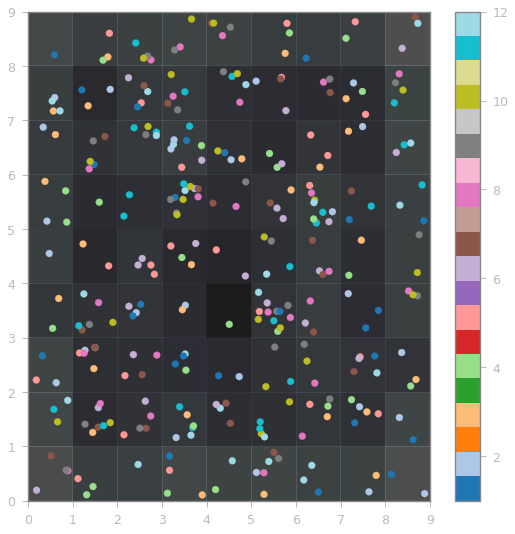

In [23]:
df_urbanhacon = pd.read_pickle("sample_TREFHT_urbanhacon_Asia.pickle")
df_urb = df_urbanhacon.copy()
df_urbanhacoff = pd.read_pickle("sample_TREFHT_urbanhacoff_Asia.pickle")
df_urbanhacon.drop(columns=["ID", "base"], inplace=True)
df_urbanhacoff.drop(columns=["ID", "base"], inplace=True)
df_samples = df_urbanhacon - df_urbanhacoff
data = df_samples[df_samples.columns[:]]
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values
som = plot_samples(data, df_urb, "difference_TREFHT_Asia.p")

In [24]:
w_x, w_y = zip(*[som.winner(d) for d in data])
w_x = np.array(w_x)
w_y = np.array(w_y)

In [25]:
print(df_samples.shape)
print(w_x.shape)
print(w_y.shape)
datas = df_samples[df_samples.columns[:]]
datas = (datas - np.mean(datas, axis=0)) / np.std(datas, axis=0)

(300, 3904)
(300,)
(300,)


In [26]:
df_winners = pd.DataFrame()  # df_samples.copy()
df_winners["w_x"] = w_x
df_winners["w_y"] = w_y
df_winners["base"] = df_urb["ID"].values

`df_winners` shows the corresponding nodes where the sample belongs.

In [27]:
df_winners

,w_x,w_y,base
0,7,6,2032-02-01 00:00:00
1,7,6,2032-03-01 00:00:00
2,7,8,2032-04-01 00:00:00
3,7,8,2032-05-01 00:00:00
4,8,8,2032-06-01 00:00:00
...,...,...,...
295,4,8,2036-09-01 00:00:00
296,4,8,2036-10-01 00:00:00
297,3,7,2036-11-01 00:00:00
298,0,7,2036-12-01 00:00:00


## Map out node members

[cftime.DatetimeNoLeap(2040, 9, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2040, 10, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2041, 4, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2041, 6, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2041, 8, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2044, 5, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2044, 8, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2044, 9, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2044, 10, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2044, 11, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2044, 12, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2045, 1, 1, 0, 0, 0, 0, has_year_zero=True)]
2040-08-04 00:00:00
2040-09-03 00:00:00
2041-03-04 00:00:00
2041-05-04 00:00:00


/tmp/ipykernel_7947/3314193582.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lats = df_on.variables['lat'][:]
/tmp/ipykernel_7947/3314193582.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lons = df_on.variables['lon'][:]
/tmp/ipykernel_7947/3314193582.py:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To

2041-07-04 00:00:00
2044-04-03 00:00:00
2044-07-04 00:00:00
2044-08-04 00:00:00
2044-09-03 00:00:00
2044-10-04 00:00:00
2044-11-03 00:00:00
2044-12-04 00:00:00


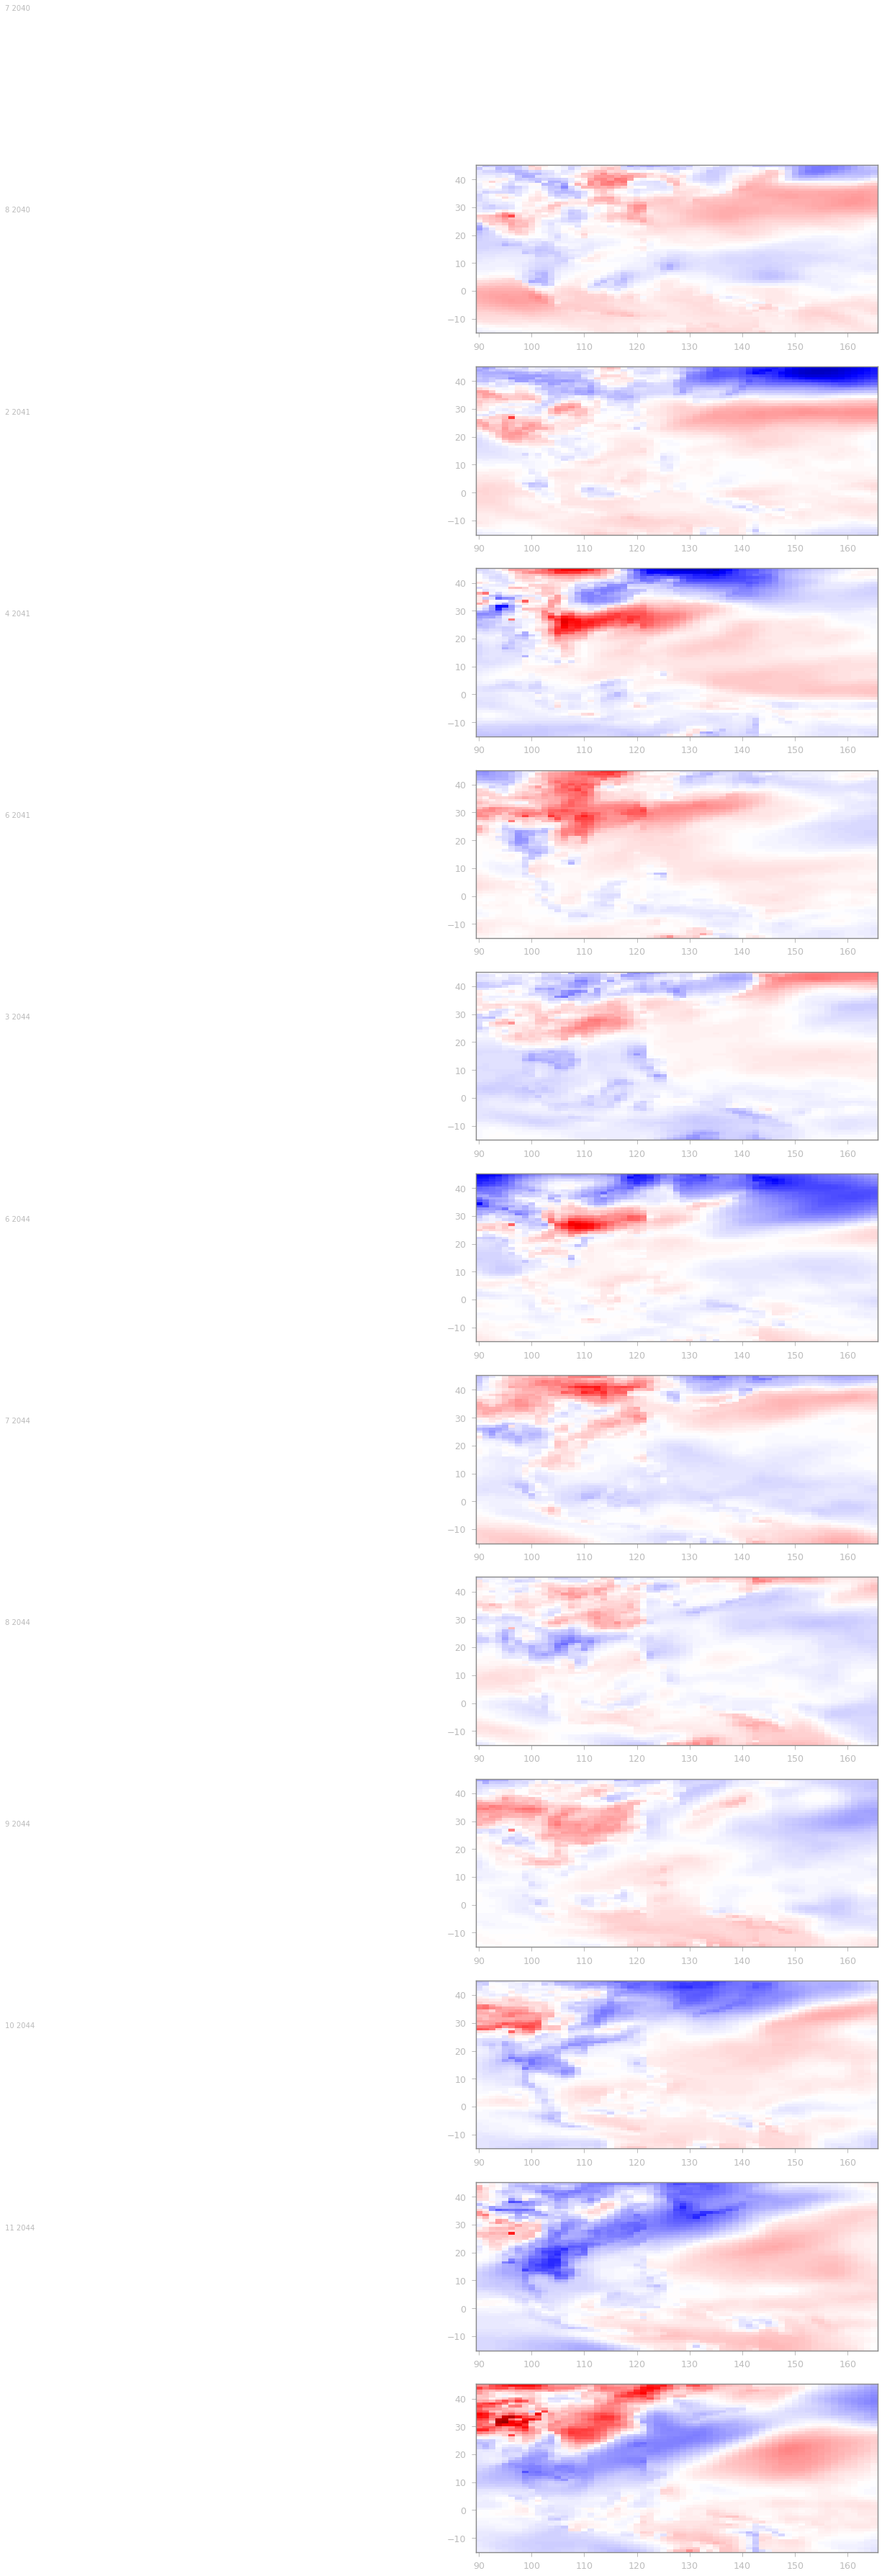

In [28]:
target_x = 5
target_y = 3
var = "TREFHT"
filelist = glob("/work/alvin/CESM/scenarios/Asia/*urbanhacon*.nc")
dateselections = df_winners.iloc[(w_x == target_x) & (w_y == target_y)]["base"].values
print(dateselections)
fig, axs = plt.subplots(
    dateselections.shape[0], 1, figsize=(10, 5 * dateselections.shape[0] + 1)
)
for count, ides in enumerate(dateselections):
    isel = ides - timedelta(weeks=4)
    print(isel)
    year = isel.strftime("%Y")
    month = int(isel.strftime("%m")) - 1
    ifil = list(filter(lambda x: year in x, filelist))[0]
    df_on = Dataset(ifil)
    if count == 0:
        lats = df_on.variables["lat"][:]
        lons = df_on.variables["lon"][:]
        ny = lats.shape[0]
        nx = lons.shape[0]
    df_off = Dataset(ifil.replace("urbanhacon", "urbanhacoff"))
    idata = df_on.variables[var][month, :, :]
    idata = idata - df_off.variables[var][month, :, :]
    m = Basemap(
        llcrnrlon=np.min(lons),
        llcrnrlat=np.min(lats),
        urcrnrlon=np.max(lons),
        urcrnrlat=np.max(lats),
        resolution="c",
        ax=axs[count],
    )
    lons1, lats1 = m.makegrid(nx, ny)
    x, y = m(lons1, lats1)
    ax1 = axs[count].pcolormesh(x, y, idata, vmin=-10.0, vmax=10.0, cmap=plt.cm.seismic)
    axs[count].text(
        0.1,
        100.0,
        f"{month} {year}",
        horizontalalignment="left",
        verticalalignment="bottom",
    )
# cbar = fig.colorbar(ax1,ax=axs[count],orientation='horizontal')
plt.show()

## Identify the node members over the time-series

In [29]:
dateselections

array([cftime.DatetimeNoLeap(2040, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2040, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2041, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2041, 6, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2041, 8, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2044, 5, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2044, 8, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2044, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2044, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2044, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2044, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2045, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)

/tmp/ipykernel_7947/2219174788.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  area = area_df.variables['area'][:,:]
/tmp/ipykernel_7947/2219174788.py:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  date = num2date(date,date.units,date.calendar,only_use_cftime_datetimes=False)
/tmp/ipykernel_7947/2219174788.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdoc

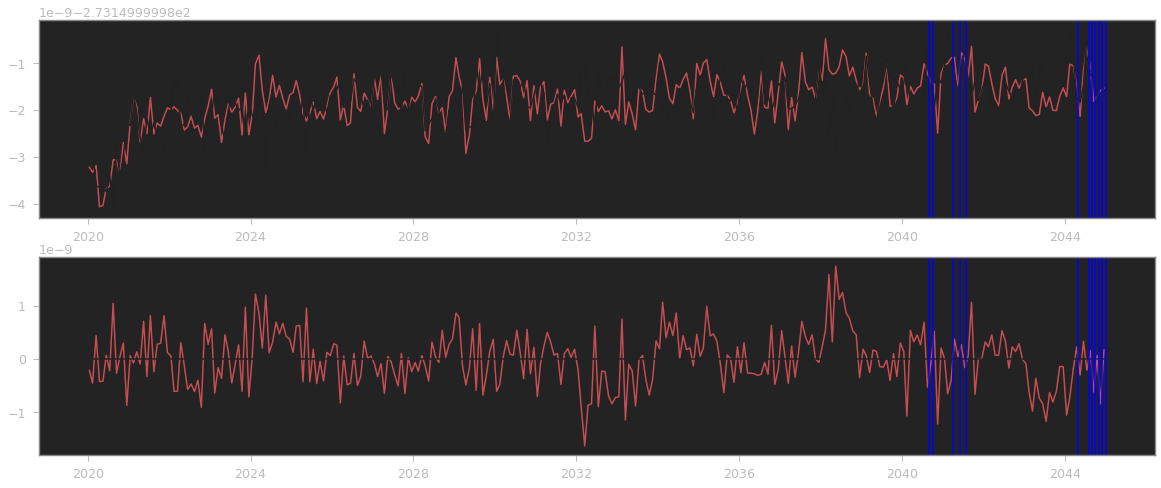

In [30]:
variable = "PRECL"
CESM_work = "/work/alvin/CESM/"
area_df = Dataset(CESM_work + "base/domain.lnd.fv0.9x1.25_gx1v7.151020.nc")
area = area_df.variables["area"][:, :]
area = area / np.mean(area)
area = area[np.newaxis, :, :]


def acquire_date(ifil):
    df = Dataset(ifil)
    date = df.variables["time"]
    date = num2date(date, date.units, date.calendar, only_use_cftime_datetimes=False)
    return np.asarray(date.data - timedelta(days=15))


def acquire_mean_variable(entry):
    df = Dataset(entry[0])
    data = df.variables[entry[1]][:] * area  # /np.sum(area)
    return np.mean(data, axis=(1, 2))


fig, axs = plt.subplots(2, 1, figsize=(20, 8))

filelist = np.sort(glob(CESM_work + "scenarios/*urbanhacon*"))
time = np.asarray(list(map(acquire_date, filelist))).ravel()
data = np.asarray(
    list(map(acquire_mean_variable, [(x, variable) for x in filelist]))
).ravel()
data1 = np.copy(data)
axs[0].plot_date(time, data - 273.15, "r-")

filelist = np.sort(glob(CESM_work + "scenarios/*urbanhacoff*"))
time = np.asarray(list(map(acquire_date, filelist))).ravel()
data = np.asarray(
    list(map(acquire_mean_variable, [(x, variable) for x in filelist]))
).ravel()
data0 = np.copy(data)
axs[0].plot_date(time, data - 273.15, "k-")
data = data1 - data0
axs[1].plot_date(time, data, "r-")
axs[1].axhline(y=0.0, color="k")
for idate in dateselections:
    axs[0].axvline(x=idate, color="blue")
    axs[1].axvline(x=idate, color="blue")

/tmp/ipykernel_7947/4170887155.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  area = area_df.variables['area'][:,:]
/tmp/ipykernel_7947/4170887155.py:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  date = num2date(date,date.units,date.calendar,only_use_cftime_datetimes=False)
/tmp/ipykernel_7947/4170887155.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdoc

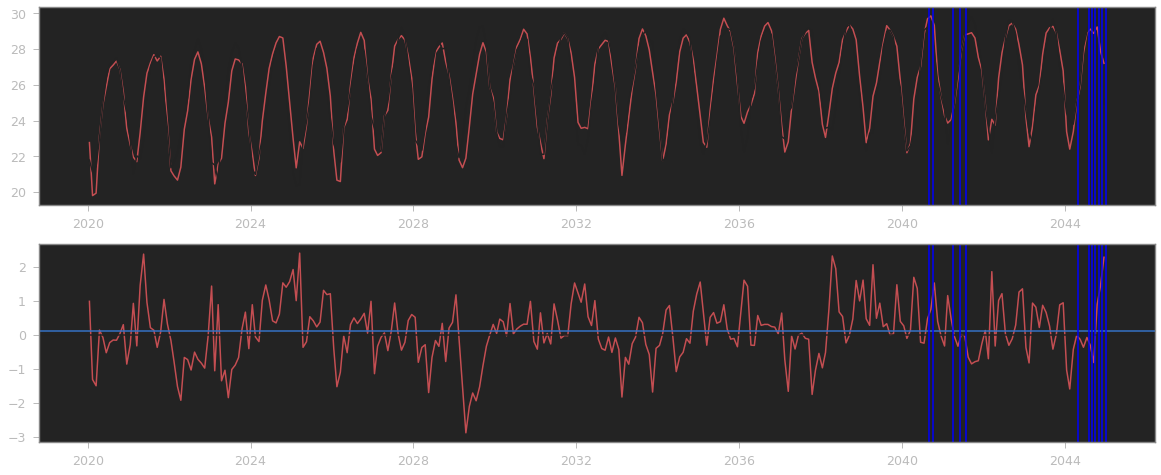

In [31]:
variable = "TREFHT"
CESM_work = "/work/alvin/CESM/"
area_df = Dataset(CESM_work + "base/domain.lnd.fv0.9x1.25_gx1v7.151020.nc")
area = area_df.variables["area"][:, :]
area = area / np.mean(area)
area = area[np.newaxis, :, :]


def acquire_date(ifil):
    df = Dataset(ifil)
    date = df.variables["time"]
    date = num2date(date, date.units, date.calendar, only_use_cftime_datetimes=False)
    return np.asarray(date.data - timedelta(days=15))


def acquire_mean_variable(entry):
    df = Dataset(entry[0])
    data = df.variables[entry[1]][:]  # *area#/np.sum(area)
    return data[:, 120, 120]  # np.mean(data,axis=(1,2))


fig, axs = plt.subplots(2, 1, figsize=(20, 8))

filelist = np.sort(glob(CESM_work + "scenarios/*urbanhacon*"))
time = np.asarray(list(map(acquire_date, filelist))).ravel()
data = np.asarray(
    list(map(acquire_mean_variable, [(x, variable) for x in filelist]))
).ravel()
data1 = np.copy(data)
axs[0].plot_date(time, data - 273.15, "r-")

filelist = np.sort(glob(CESM_work + "scenarios/*urbanhacoff*"))
time = np.asarray(list(map(acquire_date, filelist))).ravel()
data = np.asarray(
    list(map(acquire_mean_variable, [(x, variable) for x in filelist]))
).ravel()
data0 = np.copy(data)
axs[0].plot_date(time, data - 273.15, "k-")
data = data1 - data0
axs[1].plot_date(time, data, "r-")
axs[1].axhline(y=0.0, color="k")
axs[1].axhline(y=np.nanmean(data), color="b")
for idate in dateselections:
    axs[0].axvline(x=idate, color="blue")
    axs[1].axvline(x=idate, color="blue")

## Plot urban heat parameters.

/tmp/ipykernel_7947/2475293185.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  area = area_df.variables['area'][:,:]
/tmp/ipykernel_7947/2475293185.py:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  date = num2date(date,date.units,date.calendar,only_use_cftime_datetimes=False)
/tmp/ipykernel_7947/2475293185.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdoc

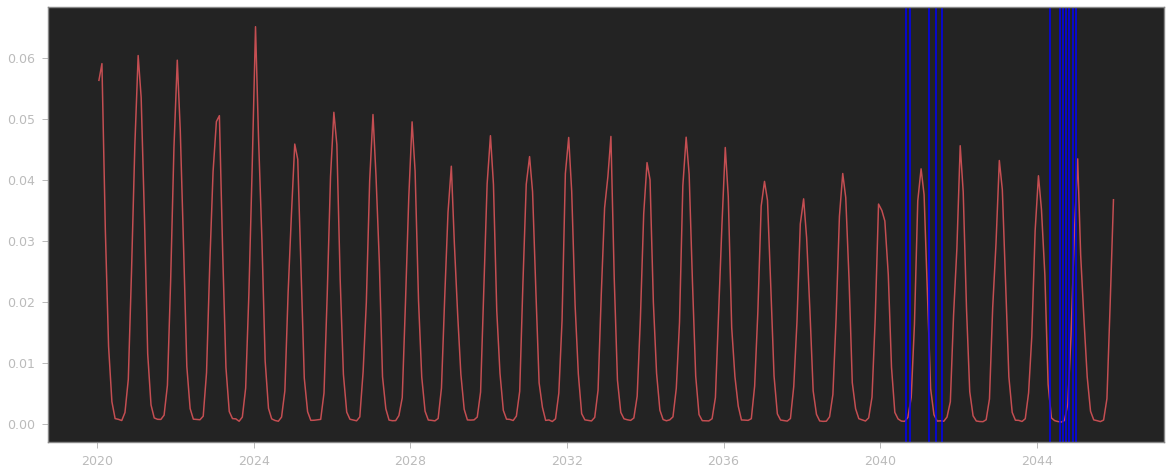

In [32]:
variable = "URBAN_HEAT"
area_df = Dataset(CESM_work + "base/domain.lnd.fv0.9x1.25_gx1v7.151020.nc")
area = area_df.variables["area"][:, :]
area = area / np.mean(area)
area = area[np.newaxis, :, :]


def acquire_date(ifil):
    df = Dataset(ifil)
    date = df.variables["time"]
    date = num2date(date, date.units, date.calendar, only_use_cftime_datetimes=False)
    return np.asarray(date.data - timedelta(days=15))


def acquire_mean_variable(entry):
    df = Dataset(entry[0])
    data = df.variables[entry[1]][:] * area  # /np.sum(area)
    return np.mean(data, axis=(1, 2))


fig, axs = plt.subplots(1, 1, figsize=(20, 8))

filelist = np.sort(
    glob(
        "/gucnas1/sims/CESM/BSSP585cmip6_fast/lnd/hist/BSSP585cmip6_fast.clm2.h0.20*.nc"
    )
)
time = np.asarray(list(map(acquire_date, filelist))).ravel()
data = np.asarray(
    list(map(acquire_mean_variable, [(x, variable) for x in filelist]))
).ravel()
data1 = np.copy(data)
axs.plot_date(time, data, "r-")
for idate in dateselections:
    axs.axvline(x=idate, color="blue")